In [ ]:
!pip install torch==2.0.0
!pip install pytorch-lightning==2.0.1
!pip install datasets==2.11.0
!pip install transformers==4.30.1
!pip install huggingface_hub==0.14.1

In [ ]:
pip install huggingface_hub==0.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.19.1 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 0.14.1 which is incompatible.
transformers 4.40.2 requires huggingface-hub<1.0,>=0.19.3, but you have huggingface-hub 0.14.1 which is incompatible.


In [ ]:
pip install datasets==2.11.0


  Using cached datasets-2.11.0-py3-none-any.whl (468 kB)


In [ ]:
!pip install torch torchvision --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Uninstalling triton-2.0.0:
      Successfully uninstalled triton-2.0.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-

In [ ]:
# Importing necessary libraries for data manipulation and visualization
import random
import numpy as np
import matplotlib.pyplot as plt
import shutil
import glob
import os

# Libraries for image processing
from PIL import Image, ImageDraw

# Utility to download a file from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Function to split your data into training and testing datasets
from sklearn.model_selection import train_test_split

# Libraries for handling datasets
import datasets
from datasets import load_dataset, concatenate_datasets, DatasetDict

# PyTorch Lightning for high-performance training
import lightning as pl
from lightning import Trainer

# PyTorch for building and training neural networks
import torch
import torch.nn as nn

# DataLoader for creating an iterable over the dataset
from torch.utils.data import DataLoader

# Libraries for image transformations
from torchvision import transforms
from torchvision.transforms import ToPILImage, ToTensor

# Transformers library for handling models
from transformers import AutoModelForObjectDetection
from transformers import YolosFeatureExtractor, YolosForObjectDetection

In [ ]:
# Load 30% of the train dataset
dataset = load_dataset("detection-datasets/fashionpedia", split='train[:30%]')

# Generate the split indices
train_val_test_split = dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% for val and test
val_test_split = train_val_test_split['test'].train_test_split(test_size=0.5, seed=42)  # Split the 20% equally into val and test

# Store the splits back into a DatasetDict
final_splits = DatasetDict({
    'train': train_val_test_split['train'],
    'val': val_test_split['train'],
    'test': val_test_split['test']
})

# Unpack the DatasetDict to train, val, test datasets
train_dataset, val_dataset, test_dataset = final_splits['train'], final_splits['val'], final_splits['test']


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--fashionpedia-fd367b48ab385b58/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
test_dataset[0]

{'image_id': 14991,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=676x1024>,
 'width': 676,
 'height': 1024,
 'objects': {'bbox_id': [117814, 117815, 117816, 117817, 117818],
  'category': [23, 23, 6, 1, 14],
  'bbox': [[174.0, 862.0, 299.0, 969.0],
   [309.0, 634.0, 420.0, 759.0],
   [127.0, 530.0, 380.0, 903.0],
   [226.0, 221.0, 420.0, 610.0],
   [254.0, 97.0, 395.0, 199.0]],
  'area': [6797, 7354, 35017, 30388, 6175]}}

In [ ]:
def xyxy_to_xcycwh(box):
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [ ]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small', size=816, max_size=864)


/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
def rescale_bboxes(out_bbox, size, down=True):
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def transform(batch):
    inputs = {}
    inputs['pixel_values'] = feature_extractor(batch['image'], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [ ]:
# Apply transformations to make it compatible with the model
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)
prepared_test = test_dataset.with_transform(transform)

In [ ]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [ ]:
# The following will be used in loading batches into the model
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(prepared_test, collate_fn=collate_fn, batch_size=BATCH_SIZE)


In [ ]:
class Yolos(pl.LightningModule):

    def __init__(self, lr, weight_decay):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained("valentinafeve/yolos-fashionpedia",
                                                                 num_labels=46,
                                                                 ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def test_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("test_loss", loss)
        for k,v in loss_dict.items():
            self.log("test_" + k, v.item())

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

In [ ]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger("logs", name="detr_logs")


In [ ]:
model = Yolos(lr=2.5e-5, weight_decay=1e-4)


In [ ]:
trainer = pl.Trainer(max_epochs=3, logger=logger, accelerator="cuda", devices=1)
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.670   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.save_checkpoint('fashion_model.ckpt')


In [ ]:
# Group the categories based on types
group_tops_outerwear = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'coat', 'cape', 'dress', 'jumpsuit']
group_bottoms = ['pants', 'shorts', 'skirt']
group_footwear = ['shoe', 'sock']
group_accessories = ['glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'bag, wallet', 'scarf', 'umbrella']
group_clothing_details = ['hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper']
group_embellishments = ['applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

group_mapping = {}
for category in group_tops_outerwear:
    group_mapping[category] = 'Tops and Outerwear'
for category in group_bottoms:
    group_mapping[category] = 'Bottoms'
for category in group_footwear:
    group_mapping[category] = 'Footwear'
for category in group_accessories:
    group_mapping[category] = 'Accessories'
for category in group_clothing_details:
    group_mapping[category] = 'Clothing Details'
for category in group_embellishments:
    group_mapping[category] = 'Embellishments'

In [ ]:
color_mapping = {
    'Tops and Outerwear': '#FFC1E0',       # Light pink
    'Bottoms': '#A7F7C0',                   # Light green
    'Footwear': '#E1BEE7',                  # Light purple
    'Accessories': '#FFD8B1',                # Light orange
    'Clothing Details': '#B3E5FC',           # Light blue
    'Embellishments': '#FFF9C4'              # Light yellow
}

In [ ]:
# Load the pretrained feature extractor from the YOLO-small model
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')

# Load the model from a checkpoint, setting the learning rate and weight decay
model_tags = Yolos.load_from_checkpoint(
    checkpoint_path='/content/drive/MyDrive/clothesmodel/fashion_model.ckpt',  # Path to the checkpoint
    lr=2.5e-5,  # Learning rate for fine-tuning
    weight_decay=1e-4  # Weight decay for regularization
)

/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def idx_to_text(i):
    return cats_list[i]

cats_list = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater',
             'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt',
             'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat',
             'headband, head covering, hair accessory', 'tie',
             'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings',
             'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar',
             'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle',
             'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon',
             'rivet', 'ruffle', 'sequin', 'tassel']

# Group the categories based on types
group_tops_outerwear = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'coat', 'cape', 'dress', 'jumpsuit']
group_bottoms = ['pants', 'shorts', 'skirt']
group_footwear = ['shoe', 'sock']
group_accessories = ['glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'bag, wallet', 'scarf', 'umbrella']
group_clothing_details = ['hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper']
group_embellishments = ['applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

group_mapping = {}
for category in group_tops_outerwear:
    group_mapping[category] = 'Tops and Outerwear'
for category in group_bottoms:
    group_mapping[category] = 'Bottoms'
for category in group_footwear:
    group_mapping[category] = 'Footwear'
for category in group_accessories:
    group_mapping[category] = 'Accessories'
for category in group_clothing_details:
    group_mapping[category] = 'Clothing Details'
for category in group_embellishments:
    group_mapping[category] = 'Embellishments'

color_mapping = {
    'Tops and Outerwear': '#FFC1E0',       # Light pink
    'Bottoms': '#A7F7C0',                   # Light green
    'Footwear': '#E1BEE7',                  # Light purple
    'Accessories': '#FFD8B1',                # Light orange
    'Clothing Details': '#B3E5FC',           # Light blue
    'Embellishments': '#FFF9C4'              # Light yellow
}


def plot_results(pil_img, prob, boxes, show_image=True):
    if show_image:
        plt.figure(figsize=(16, 10))
        plt.imshow(pil_img)
        ax = plt.gca()
    unique_categories = {}

    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        category = idx_to_text(cl)
        group = group_mapping[category]
        color = color_mapping[group]

        if show_image:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=color, linewidth=1))

            # Determine the label position based on the category
            if group in ['Accessories', 'Clothing Details', 'Embellishments']:
                label_x = xmax  # Position the label in the lower right corner of the bounding box
                label_y = ymax  # Position the label in the lower right corner of the bounding box
                ha = 'right'
                va = 'bottom'
            else:
                label_x = xmin  # Position the label in the upper left corner of the bounding box
                label_y = ymin  # Position the label in the upper left corner of the bounding box
                ha = 'left'
                va = 'top'

            ax.text(label_x, label_y, category, fontsize=8, ha=ha, va=va,
                    bbox=dict(facecolor=color, alpha=0.8, pad=0.2))

        if group not in unique_categories:
            unique_categories[group] = set()
        unique_categories[group].add(category)

    if show_image:
        plt.axis('off')
        plt.show()

    for group, categories in unique_categories.items():
        # Convert categories to a list with '/' separator, then join them
        detected = ', '.join([', '.join(word.split(', ')).replace(', ', '/') for word in categories])

        # Print group and corresponding category string
        print(f"{group}: {detected}")
    print("\n\n")

def visualize_predictions(image, outputs, threshold=0.7, show_image=True):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled, show_image)


def fix_channels(t):
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)


def process_image(IMAGE_PATH, threshold=0.7, show_image=True):
    print(IMAGE_PATH)

    image = Image.open(open(IMAGE_PATH, "rb"))
    image = fix_channels(ToTensor()(image))
    image = image.resize((600, 800))

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model_tags(**inputs)

    img = visualize_predictions(image, outputs, threshold, show_image)

    return img

def process_images(image_paths, threshold=0.7, show_image=True):
    results = []
    for image_path in image_paths:
        result = process_image(image_path, threshold, show_image)
        results.append(result)
    return results

/content/WhatsApp Image 2024-05-16 at 23.54.16.jpeg


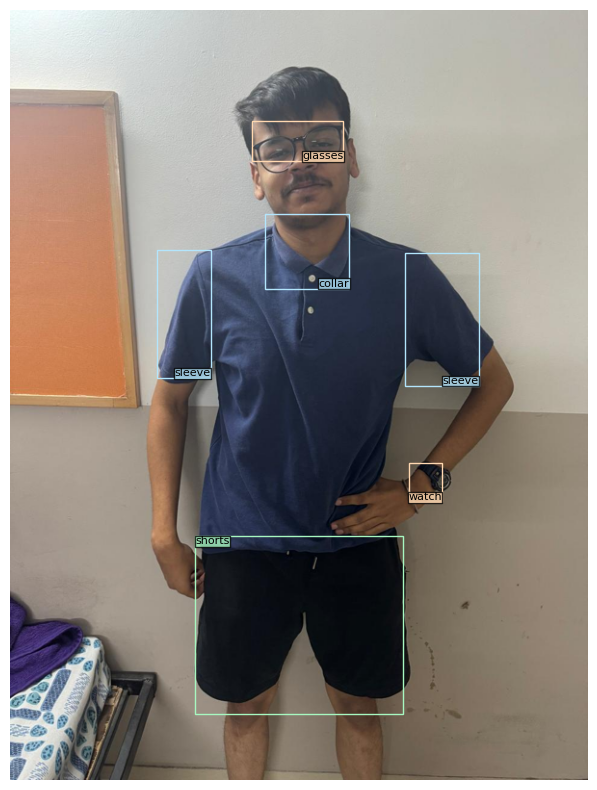

Accessories: watch, glasses
Clothing Details: collar, sleeve
Bottoms: shorts





In [ ]:
# Single image, show_image=True
IMAGE_PATH = ["/content/WhatsApp Image 2024-05-16 at 23.54.16.jpeg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=True);

/content/IMG_5731.jpg


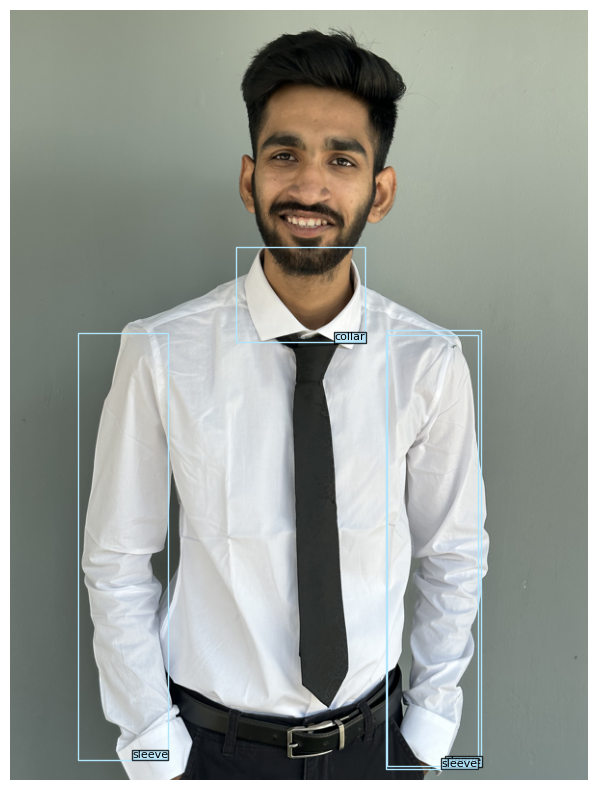

Clothing Details: collar, sleeve





In [ ]:
# Single image, show_image=True
IMAGE_PATH = ["/content/IMG_5731.jpg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=True);